### Assessment 2: Machine Learning Model Study / Project Implementation

# Section1: Import Libraries
This section imports necessary libraries and modules for handling arrays, plotting, and calculating performance metrics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Section2: Performance Metrics and Confusion Matrix Plot Function
This section defines a function to calculate classification metrics (accuracy, precision, recall, F1-score) and plot a confusion matrix.

In [ ]:
def calculate_metrics_with_plot(y_true, y_pred):


    # Calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print the results
    print("######### Performance Metrics ########")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

    # Plot confusion matrix
    ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_true)).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Section3: Node Class for Decision Tree
This section defines the Node class, representing a node in the decision tree with attributes for splitting features, thresholds, and children nodes.

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor for a tree node '''

        # For decision nodes, the index of the feature being split
        self.feature_index = feature_index
        # The threshold value for splitting
        self.threshold = threshold
        # Left subtree (for values <= threshold)
        self.left = left
        # Right subtree (for values > threshold)
        self.right = right
        # The information gain obtained from the split
        self.info_gain = info_gain

        # For leaf nodes, the predicted class value
        self.value = value

# Section4: Decision Tree Classifier Class
This section defines the DecisionTreeClassifier class, with methods for building the tree, finding the best split, computing information gain, and making predictions.

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor for the decision tree classifier '''

        # Initialize the root of the tree
        self.root = None

        # Stopping conditions
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split
        self.max_depth = max_depth  # Maximum depth of the tree

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''

        # Split dataset into features (X) and labels (Y)
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)  # Number of samples and features

        # Check stopping conditions: minimum samples and maximum depth
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # Find the best split for the current dataset
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # Check if information gain from the split is positive
            if best_split["info_gain"] > 0:
                # Recursively build the left subtree
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                # Recursively build the right subtree
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                # Return a decision node
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # If no information gain, compute the leaf node (majority class)
        leaf_value = self.calculate_leaf_value(Y)
        # Return a leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''

        # Dictionary to store details of the best split
        best_split = {}
        max_info_gain = -float("inf")  # Initialize the maximum information gain

        # Loop over each feature
        for feature_index in range(num_features):
            # Get the unique values of the current feature
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # Loop over each possible threshold
            for threshold in possible_thresholds:
                # Split the dataset based on the threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # Check if both child nodes are non-empty
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    # Get labels of the parent and child nodes
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # Calculate information gain from the split
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # Update the best split if the current info gain is higher
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # Return the details of the best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the dataset '''

        # Split the dataset into left and right subsets based on the threshold
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child):
        ''' function to compute information gain '''

        # Calculate the weighted average of the left and right subsets
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        # Calculate the gain: difference in impurity (entropy/gini) before and after the split
        gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy (impurity measure) '''

        # Get the unique class labels
        class_labels = np.unique(y)
        entropy = 0
        # Loop over each class and calculate its contribution to entropy
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def calculate_leaf_value(self, Y):
        ''' function to compute the value of the leaf node '''

        # Return the most frequent class label
        Y = list(Y)
        return max(Y, key=Y.count)

    def fit(self, X, Y):
        ''' function to train the decision tree '''

        # Combine features and labels into one dataset
        dataset = np.concatenate((X, Y), axis=1)
        # Build the tree and set the root node
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict labels for a new dataset '''

        # Predict the label for each sample in the dataset
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        # If it's a leaf node, return the predicted value (class label)
        if tree.value is not None:
            return tree.value
        # If it's a decision node, choose the path based on the feature value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# Section5: Generate and Plot Toy Dataset
This section generates a toy non-linear classification dataset using the make_moons function and plots it.

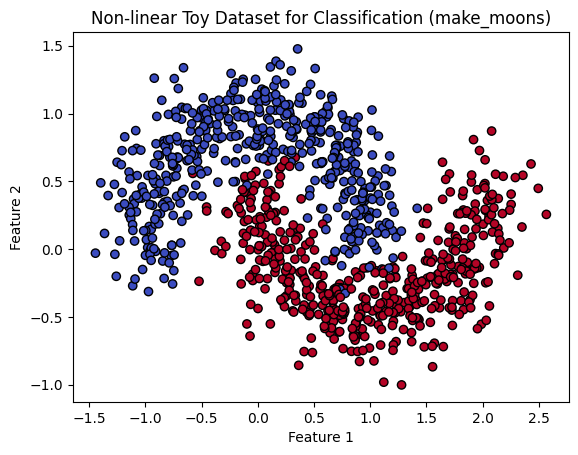

In [ ]:
# Generate a non-linear toy dataset for classification using make_moons
from sklearn.datasets import make_moons

# Create a non-linear dataset (two interleaving half circles)
X, Y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Plot the non-linear dataset
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Non-linear Toy Dataset for Classification (make_moons)")
plt.show()

# Section6: Train-Test Split and Model Training
This section splits the dataset into training and test sets and trains the decision tree classifier.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

Y_train = np.expand_dims(Y_train, axis=1)
Y_test = np.expand_dims(Y_test, axis=1)

classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)

# Section7: Model Prediction and Performance Evaluation
This section makes predictions using the trained model and evaluates its performance using the previously defined calculate_metrics_with_plot function.

######### Performance Metrics ########
Accuracy: 0.905
Precision: 0.9054082265398926
Recall: 0.905
F1-score: 0.9046228130843516


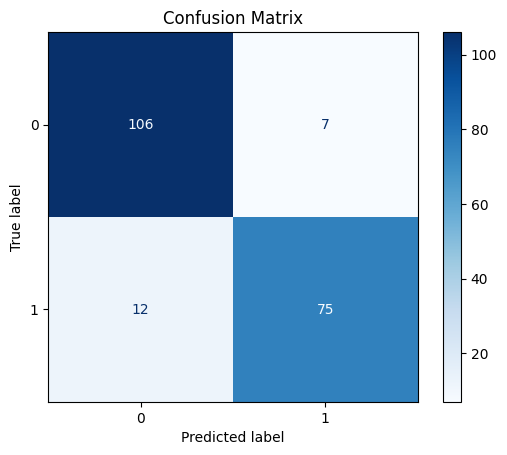

In [ ]:
Y_pred = classifier.predict(X_test)
calculate_metrics_with_plot(Y_test,Y_pred)